In [22]:
# Basic operations
import numpy as np
import pandas as pd
import gensim
from importlib import reload

# LDA
from collections import Counter

# aesthetics
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from source import topic_modelling as tm

In [2]:
"""
First, we will perform classical exploratory analysis.
"""

df = pd.read_pickle('dfs/preprocessed-cleaned-df.pkl')
df.head()

,prompt,professor,student,professor_clean,student_clean,prompt_clean
0,You happen to know that Tim and Harry have rec...,"That's a great question! You see, our brains a...","Professor, I was thinking about how I conclude...","[great, question, brain, wire, look, plausible...","[professor, think, conclude, roommate, breakfa...","[happen, know, tim, harry, recently, terrible,..."
0,You happen to know that Tim and Harry have rec...,"Of course, you could be wrong! But here's the ...","But isn't that just an assumption? I mean, I c...","[course, wrong, thing, reasoning, base, probab...","[assumption, mean, wrong, roommate, eat, break...","[happen, know, tim, harry, recently, terrible,..."
0,You happen to know that Tim and Harry have rec...,"Ah, great example! This is where the concept o...","That makes sense, I guess. But what about case...","[great, example, concept, abduction, come, abd...","[make, sense, guess, case, explanation, clear,...","[happen, know, tim, harry, recently, terrible,..."
0,You happen to know that Tim and Harry have rec...,Exactly! Our minds are wired to seek patterns ...,"Yeah, I think so. It's like, our brains are al...","[exactly, mind, wire, seek, pattern, explanati...","[yeah, think, like, brain, try, find, story, e...","[happen, know, tim, harry, recently, terrible,..."
1,\n Even if it is true that we routinely rely o...,"Well, my inquisitive student, that's a great q...","Professor Phil, do we always choose the simple...","[inquisitive, student, great, question, mind, ...","[professor, phil, choose, simple, explanation,...","[true, routinely, rely, abductive, reasoning, ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 0 to 19
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt           83 non-null     object
 1   professor        83 non-null     object
 2   student          83 non-null     object
 3   professor_clean  83 non-null     object
 4   student_clean    83 non-null     object
 5   prompt_clean     83 non-null     object
dtypes: object(6)
memory usage: 4.5+ KB


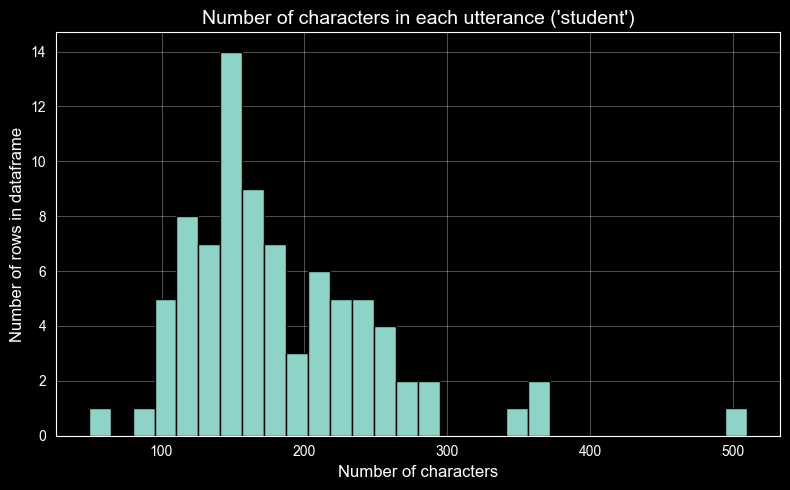

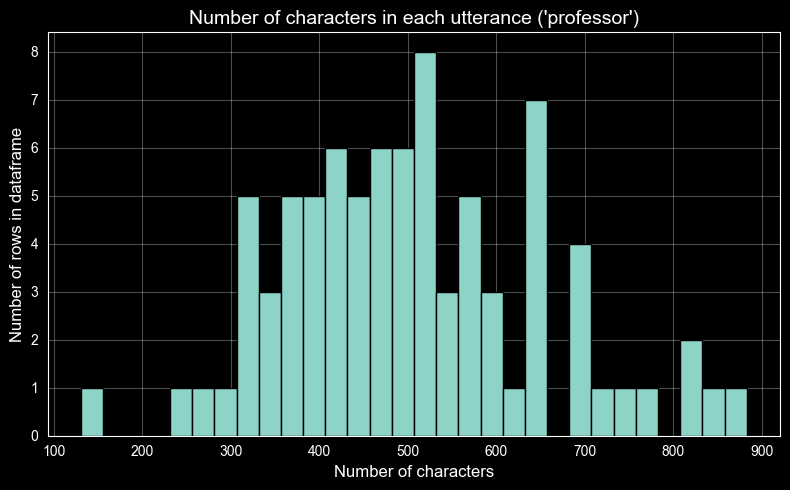

In [4]:
# number of characters in each utterance of each speaker
for column in ['student', 'professor']:
    plt.figure(figsize=(8, 5))
    df[column].str.len().hist(bins=30, edgecolor='black')
    plt.title(f"Number of characters in each utterance ('{column}')", fontsize=14)
    plt.xlabel("Number of characters", fontsize=12)
    plt.ylabel("Number of rows in dataframe", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

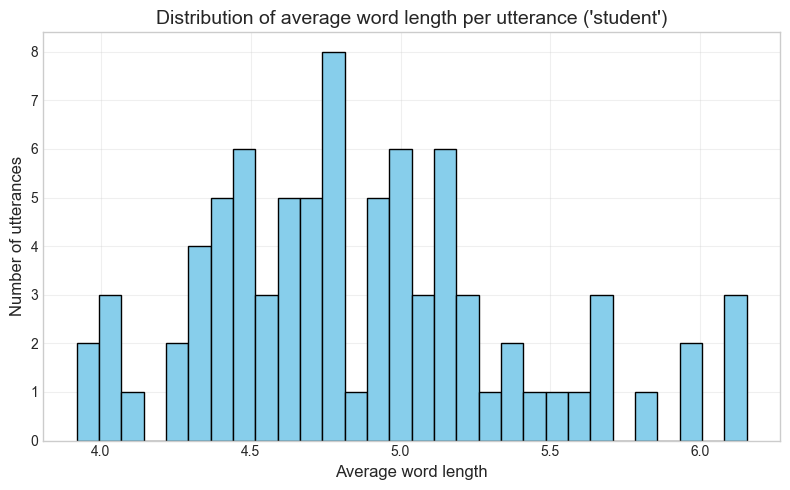

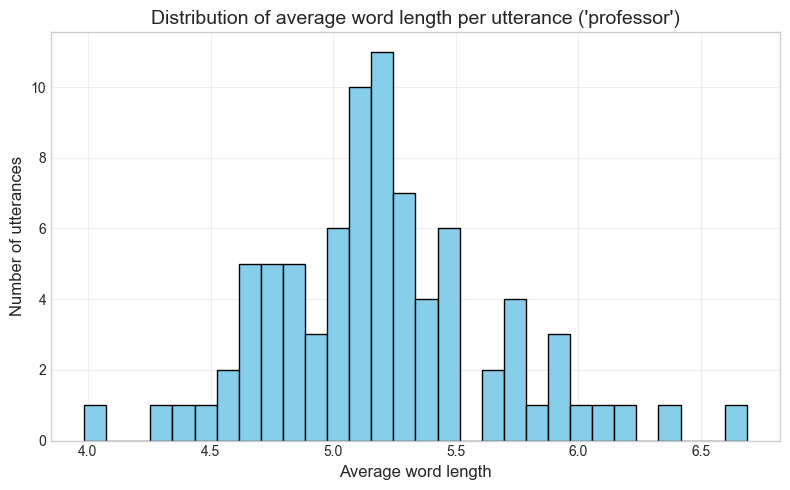

In [5]:
# distribution of average word length per utterance
plt.style.use('seaborn-v0_8-whitegrid')
for column in ['student', 'professor']:
    plt.figure(figsize=(8, 5))
    df[column].str.split() \
        .apply(lambda x: [len(i) for i in x]) \
        .map(np.mean) \
        .hist(bins=30, edgecolor='black', color='skyblue')

    plt.title(f"Distribution of average word length per utterance ('{column}')", fontsize=14)
    plt.xlabel("Average word length", fontsize=12)
    plt.ylabel("Number of utterances", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

C:\Users\kalus\AppData\Local\Temp\ipykernel_9540\2189832164.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


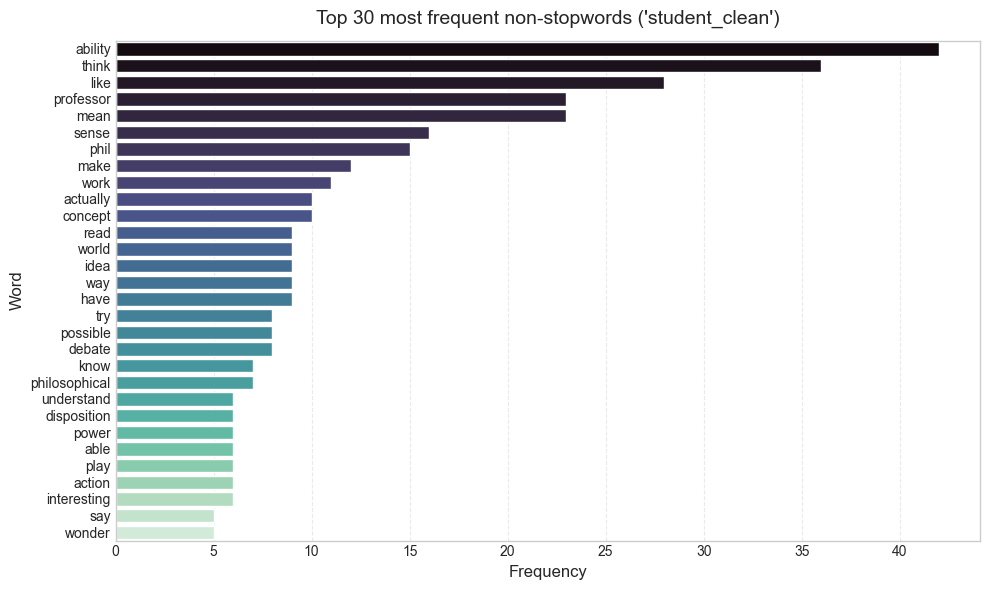

C:\Users\kalus\AppData\Local\Temp\ipykernel_9540\2189832164.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


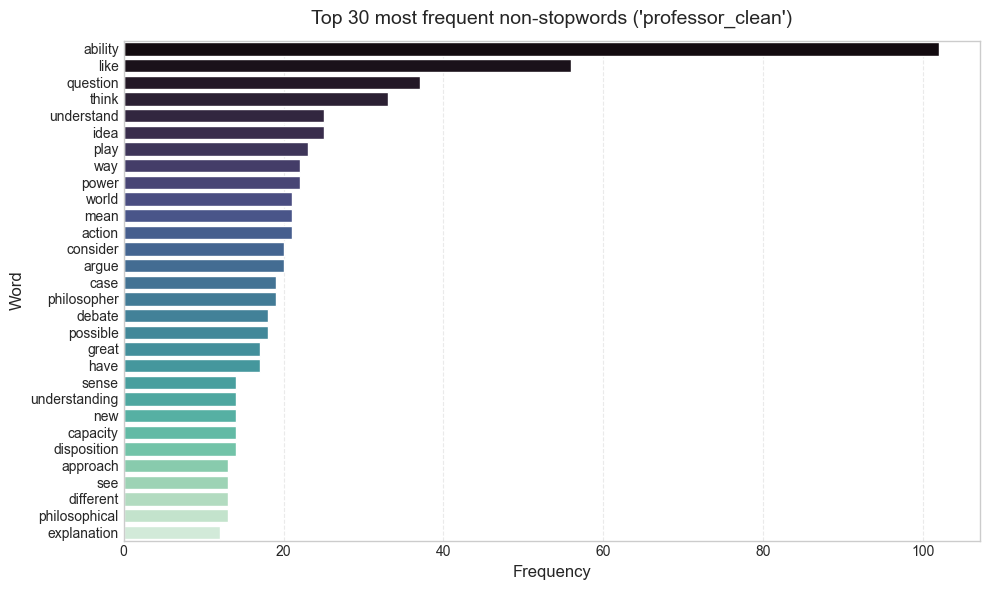

In [6]:
# The 30 most popular words
for column in ['student_clean', 'professor_clean']:
    corpus = [word for lemmas in df[column] for word in lemmas]
    counter=Counter(corpus)
    most=counter.most_common(30)
    words, counts = zip(*most)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="mako")
    plt.title(f"Top {30} most frequent non-stopwords ('{column}')", fontsize=14, pad=12)
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [7]:
"""
Now it's time for topic modelling
"""
texts = df['professor_clean'] + df['student_clean']
dic=gensim.corpora.Dictionary(texts)
bow_corpus = [dic.doc2bow(doc) for doc in texts] # BOW

[I 2026-01-17 14:11:33,116] A new study created in memory with name: LDA-topic-modelling
[I 2026-01-17 14:11:55,960] Trial 0 finished with value: 0.4171284236565819 and parameters: {'num_topics': 17}. Best is trial 0 with value: 0.4171284236565819.
[I 2026-01-17 14:12:19,068] Trial 1 finished with value: 0.3466666475966093 and parameters: {'num_topics': 15}. Best is trial 0 with value: 0.4171284236565819.
[I 2026-01-17 14:12:48,724] Trial 2 finished with value: 0.2774079994873502 and parameters: {'num_topics': 9}. Best is trial 0 with value: 0.4171284236565819.


Best trial: {'num_topics': 17}


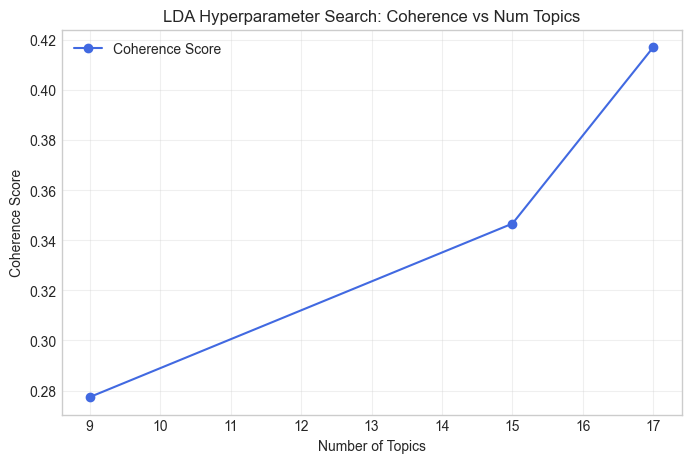

In [8]:
# Search the space for the best solution
ev_metric = tm.find_best_LDA(
    corpus=bow_corpus,
    id2word=dic,
    passes=5,
    texts=texts,
    coherence='c_v',
    n_trials=3
)
ev_metric.to_csv(f'dfs/LDA_ev_metric.csv')

In [9]:
print(ev_metric.head())

   number  coherence_score             datetime_start  \
0       0         0.417128 2026-01-17 14:11:33.117214   
1       1         0.346667 2026-01-17 14:11:55.961735   
2       2         0.277408 2026-01-17 14:12:19.069767   

           datetime_complete               duration  params_num_topics  \
0 2026-01-17 14:11:55.960452 0 days 00:00:22.843238                 17   
1 2026-01-17 14:12:19.068819 0 days 00:00:23.107084                 15   
2 2026-01-17 14:12:48.724015 0 days 00:00:29.654248                  9   

      state  
0  COMPLETE  
1  COMPLETE  
2  COMPLETE  


In [10]:
# Run the best LDA model
best_lda = tm.create_LDA_model(corpus=bow_corpus,
                                num_topics=17,
                                id2word=dic,
                                passes=10)

In [11]:
# Plot the results
tm.plot_lda_vis(lda_model=best_lda,
                corpus=bow_corpus,
                dic=dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.067255 -0.114482       1        1  10.275954
9      0.134923 -0.021759       2        1   9.917954
7      0.071587 -0.025760       3        1   8.293166
12    -0.150987 -0.135455       4        1   7.423998
10    -0.043045 -0.000478       5        1   7.225830
6      0.024207  0.100961       6        1   6.621921
8      0.008396 -0.082524       7        1   6.332315
4     -0.156037  0.048092       8        1   6.135014
0     -0.029139  0.156674       9        1   5.995409
2      0.104729 -0.022467      10        1   5.870773
14    -0.010882 -0.017123      11        1   5.509693
11    -0.131783 -0.057357      12        1   5.102748
3      0.062817  0.009407      13        1   3.979570
5      0.011264  0.016778      14        1   3.645762
15     0.067687  0.034932      15        1   3.125429
1      0.049520  0.020689      16        1   2.929837
13    -0.080512  0.089872      17        1   1.614625, topic_info=            Term        Freq       Total Category  logprob  loglift
352      ability  115.000000  115.000000  Default  30.0000  30.0000
433        power   21.000000   21.000000  Default  29.0000  29.0000
110        world   24.000000   24.000000  Default  28.0000  28.0000
425  disposition   15.000000   15.000000  Default  27.0000  27.0000
457       debate   20.000000   20.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
263   individual    0.522050    7.501155  Topic17  -4.8470   1.4610
139         phil    0.521904   12.688309  Topic17  -4.8473   0.9351
987       unique    0.521733    4.368627  Topic17  -4.8477   2.0010
18         great    0.521702   15.414186  Topic17  -4.8477   0.7401
935     identity    0.521265    5.906911  Topic17  -4.8486   1.6984

[1030 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
66        1  0.154689   abduction
66        3  0.464067   abduction
66        4  0.309378   abduction
244       1  0.216999  abhidharma
244      11  0.216999  abhidharma
...     ...       ...         ...
177       4  0.159732         yes
177       5  0.159732         yes
177       6  0.159732         yes
177      11  0.159732         yes
177      12  0.319464         yes

[1718 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 10, 8, 13, 11, 7, 9, 5, 1, 3, 15, 12, 4, 6, 16, 2, 14])

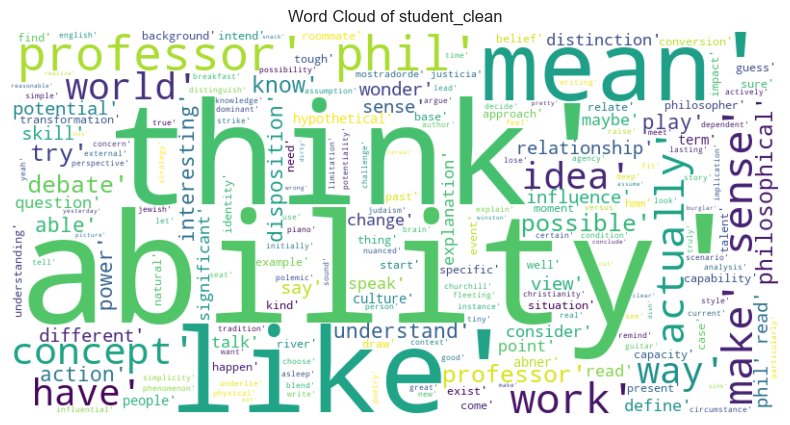

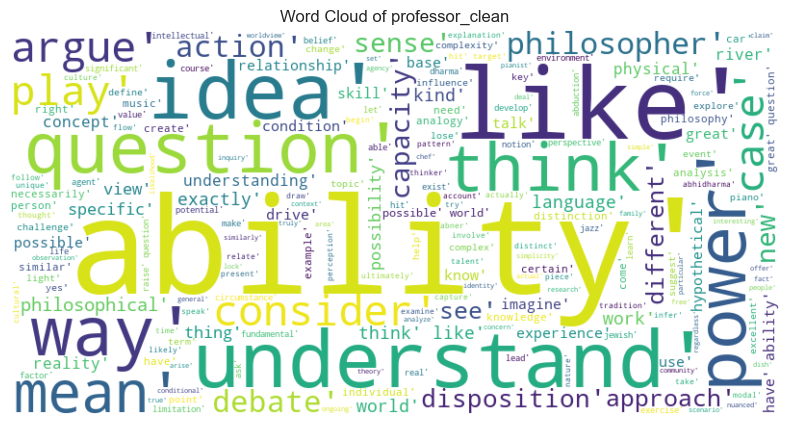

In [12]:
# Generate wordcloud
for column in ['student_clean', 'professor_clean']:
    wd_text = " ".join(df[column].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wd_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of {column}")
    plt.show()

In [19]:
"""
3) Compute Zip's law distribution
"""
from source import zipfslaw as zl

print("-----------------")
print("| Zipf's Law    |")

try:
    with open("dfs/preprocessed-df.csv", "r", encoding="latin-1") as f:
        text = f.read()
        f.close()
        zipf_table = zl.generate_zipf_table(text, 200)
        zl.print_zipf_table(zipf_table)
except IOError as e:
    print(e)

-----------------
| Zipf's Law    |
--------------------------------------------------------------------------------
|Rank|    Word    |Actual Freq | Zipf Frac  | Zipf Freq  |Actual Diff |Pct Diff|
--------------------------------------------------------------------------------
|   1|the         |        2299|         1/1|     2299.00|        0.00| 100.00%|
|   2|of          |        1600|         1/2|     1149.50|      450.50| 139.19%|
|   3|a           |        1289|         1/3|      766.33|      522.67| 168.20%|
|   4|to          |        1258|         1/4|      574.75|      683.25| 218.88%|
|   5|that        |         995|         1/5|      459.80|      535.20| 216.40%|
|   6|and         |         959|         1/6|      383.17|      575.83| 250.28%|
|   7|is          |         783|         1/7|      328.43|      454.57| 238.41%|
|   8|in          |         770|         1/8|      287.38|      482.62| 267.94%|
|   9|it          |         465|         1/9|      255.44|      209.56| 1

In [47]:
"""
4) Let's compute entropy of the responses
"""
from source import entropy as ep
reload(ep)
df = pd.read_pickle('dfs/preprocessed-cleaned-df.pkl')
df = ep.compute_entropy_dataset(df, ['student', 'professor'])

# set ID for each conversation
df['conversation_id'] = df.index

# index for each row
df['row_id'] = np.arange(len(df)) + 1
df.set_index('row_id', inplace=True)
df.head()
# df.groupby('ID').mean()


,prompt,professor,student,professor_clean,student_clean,prompt_clean,student_ent,professor_ent,conversation_id
row_id,,,,,,,,,
1,You happen to know that Tim and Harry have rec...,"That's a great question! You see, our brains a...","Professor, I was thinking about how I conclude...","[great, question, brain, wire, look, plausible...","[professor, think, conclude, roommate, breakfa...","[happen, know, tim, harry, recently, terrible,...",0.01231,0.00792,0
2,You happen to know that Tim and Harry have rec...,"Of course, you could be wrong! But here's the ...","But isn't that just an assumption? I mean, I c...","[course, wrong, thing, reasoning, base, probab...","[assumption, mean, wrong, roommate, eat, break...","[happen, know, tim, harry, recently, terrible,...",0.03902,0.00953,0
3,You happen to know that Tim and Harry have rec...,"Ah, great example! This is where the concept o...","That makes sense, I guess. But what about case...","[great, example, concept, abduction, come, abd...","[make, sense, guess, case, explanation, clear,...","[happen, know, tim, harry, recently, terrible,...",0.01541,0.00771,0
4,You happen to know that Tim and Harry have rec...,Exactly! Our minds are wired to seek patterns ...,"Yeah, I think so. It's like, our brains are al...","[exactly, mind, wire, seek, pattern, explanati...","[yeah, think, like, brain, try, find, story, e...","[happen, know, tim, harry, recently, terrible,...",0.02672,0.01755,0
5,\n Even if it is true that we routinely rely o...,"Well, my inquisitive student, that's a great q...","Professor Phil, do we always choose the simple...","[inquisitive, student, great, question, mind, ...","[professor, phil, choose, simple, explanation,...","[true, routinely, rely, abductive, reasoning, ...",0.03527,0.00688,1
